In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.3
pymc3 version: 3.6
exoplanet version: 0.1.3
starry version: 1.0.0


# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

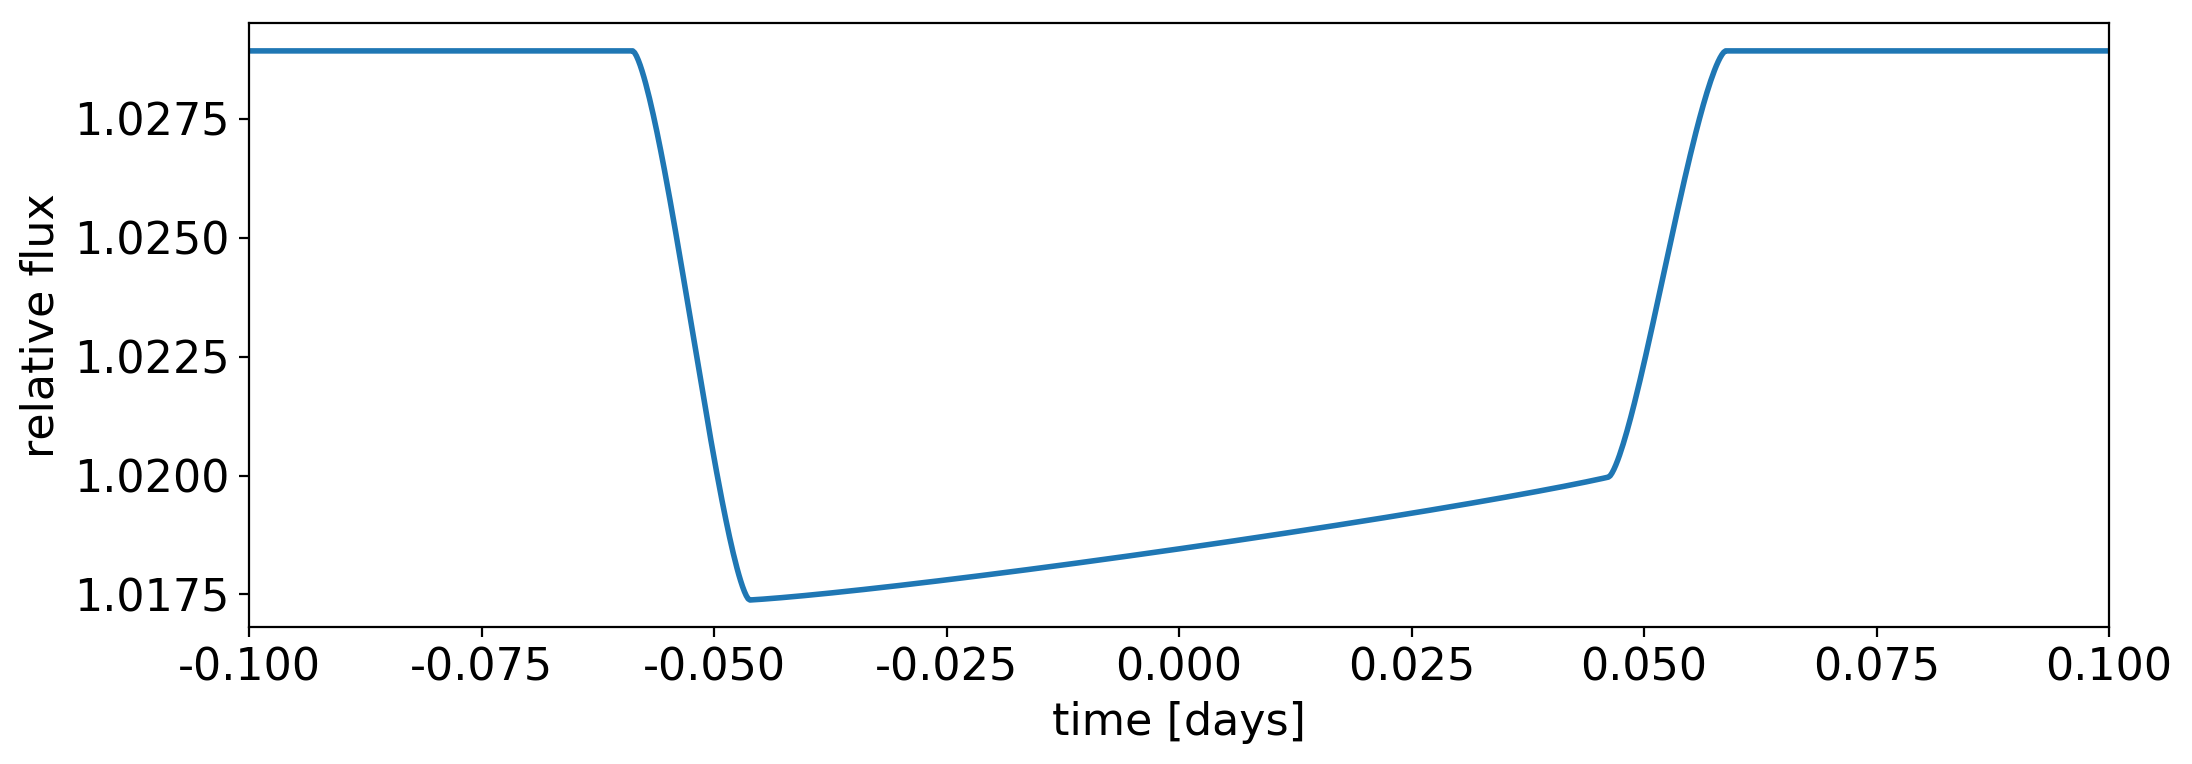

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo
from starry.ops import LightCurve

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456, b=0.4)

# Compute a light curve using starry
lmax = 1
t = np.linspace(-0.1, 0.1, 1000)
np.random.seed(41)
y_true = 0.1 * np.random.randn((lmax + 1) ** 2)
y_true[0] = 1.0
op = LightCurve(lmax)
light_curve = op.get_light_curve(orbit=orbit, r=0.1, t=t, y=y_true).eval()

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(t.min(), t.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [35]:
np.random.seed(123)
period_true = np.random.uniform(5, 20)
t0_true = period_true * np.random.rand()
t = np.arange(0, 80, 0.02)
fluxerr = 5e-4

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009) and for the joint radius ratio and impact parameter distribution we'll use the parameterization from [Espinoza (2018)](https://arxiv.org/abs/1811.04859).
Both of these reparameterizations are implemented in *exoplanet* as custom *PyMC3* distributions (:class:`exoplanet.distributions.QuadLimbDark` and :class:`exoplanet.distributions.RadiusImpact` respectively).

In [36]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    
    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0_true, sd=1.0)
    
    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(period_true), sd=0.1)
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # Normal distributions for the map coeffs
    y = pm.Normal("y", mu=y_true, sd=1.0, shape=len(y_true))

    # Normal distributions for r and b
    r = pm.Normal("r", mu=0.1, sd=0.01)
    b = pm.Normal("b", mu=0.4, sd=0.1)
    
    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
    
    # Compute the model light curve using starry
    light_curve = op.get_light_curve(orbit=orbit, r=r, t=t, y=y) + mean
    
    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curve", light_curve)
    
    # In this line, we simulate the dataset that we will fit
    flux = xo.eval_in_model(light_curve)
    flux += fluxerr * np.random.randn(len(flux))
    
    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=fluxerr, observed=flux)
    
    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = pm.find_MAP(start=model.test_point)

/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = 24,796, ||grad|| = 11,114: 100%|██████████| 19/19 [00:00<00:00, 655.18it/s]  


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

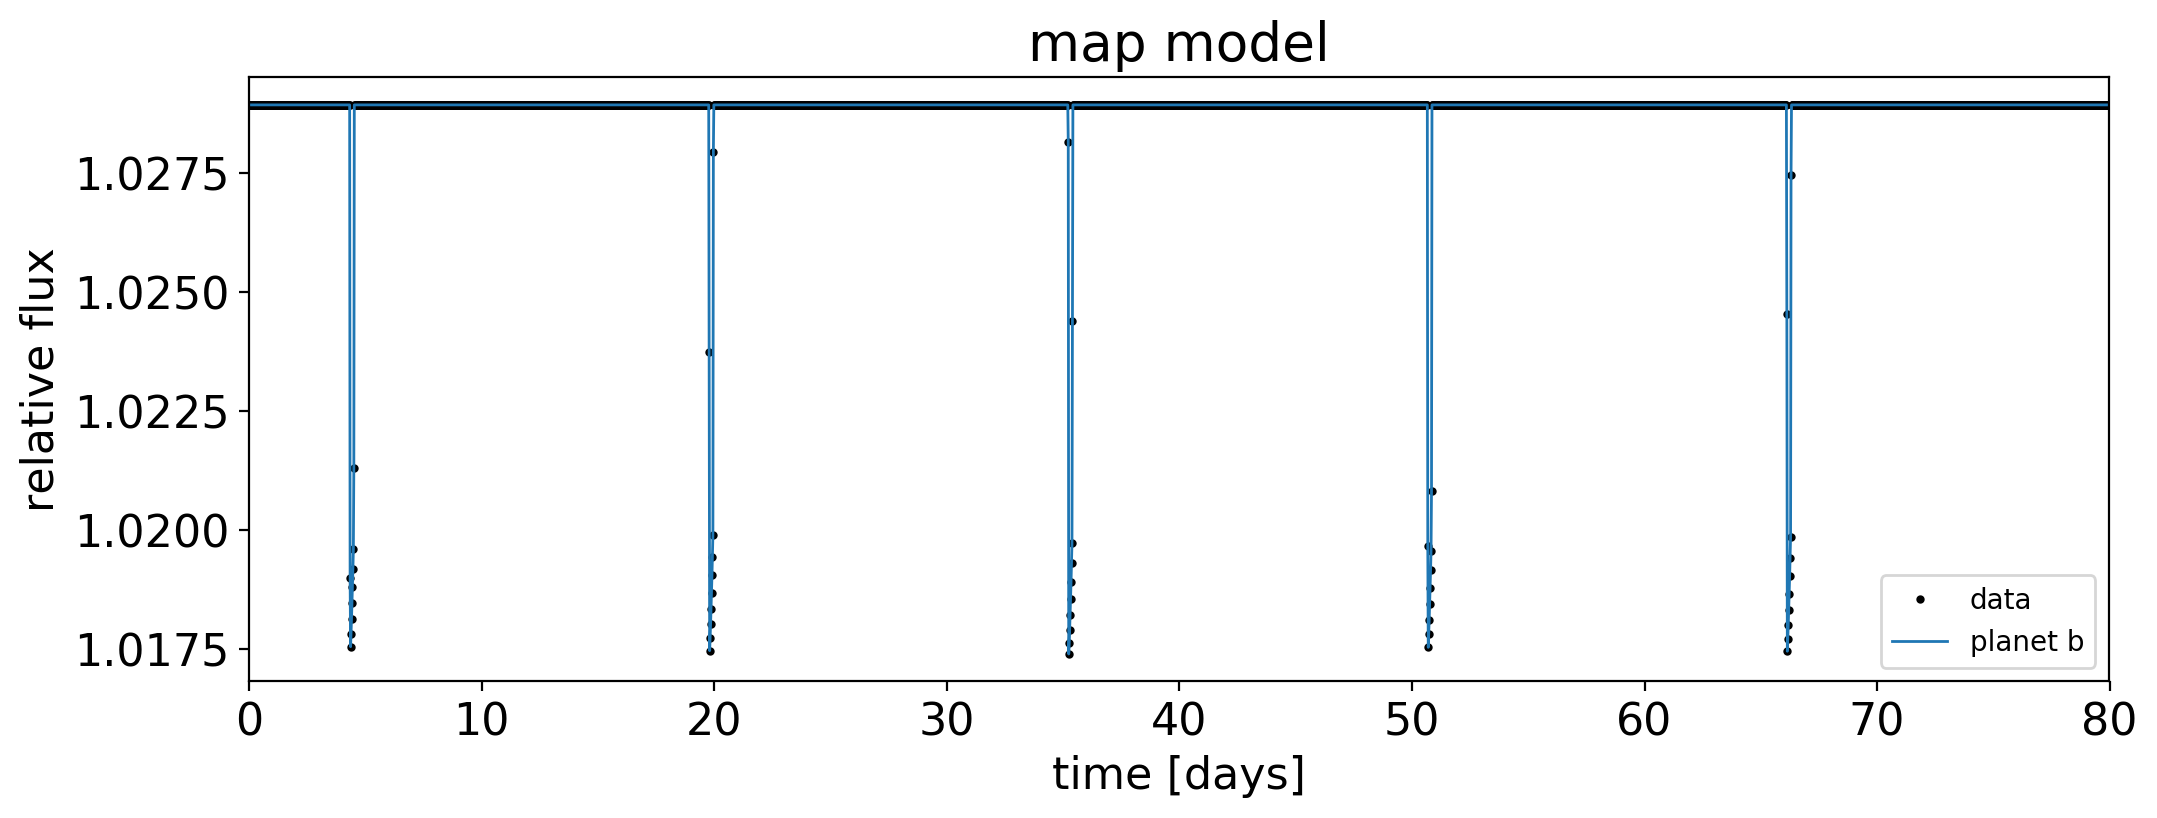

In [37]:
plt.plot(t, flux, ".k", ms=4, label="data")
plt.plot(t, map_soln["light_curve"], lw=1, label="planet {0}".format("b"))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
plt.title("map model");

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use the :class:`exoplanet.PyMC3Sampler` to sample.

In [38]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(window=100, finish=200)
with model:
    burnin = sampler.tune(tune=2500, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

Sampling 4 chains: 100%|██████████| 808/808 [00:06<00:00, 75.93draws/s] 
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, r, y, logP, t0, mean]
Sampling 4 chains: 100%|██████████| 12000/12000 [01:40<00:00, 41.72draws/s] 
The acceptance probability does not match the target. It is 0.9759036895974483, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.973700188353795, but should be close to 0.9. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9723693478585977, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9750245127160079, but should be close to 0.9. Try to increase the number of tuning steps.


After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [39]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "y", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
period,15.446808,0.000191,0.000002,15.446442,15.447189,15051.146083,0.999942
t0,4.420736,0.000519,0.000005,4.419745,4.421769,13635.560539,1.000110
r,0.095272,0.005710,0.000092,0.084352,0.106653,3889.519903,1.000982
b,0.407190,0.009929,0.000108,0.387105,0.425999,8865.893258,1.000144
y__0,1.061840,0.503018,0.004557,0.042969,2.032199,10096.766852,0.999954
y__1,0.127494,0.711735,0.006671,-1.230900,1.579508,9549.694531,0.999941
y__2,0.006266,0.038407,0.000388,-0.065322,0.085531,10555.871696,0.999953
y__3,-0.100841,0.016440,0.000233,-0.133681,-0.070106,5234.931222,1.001073
mean,-0.040141,0.502898,0.004563,-1.000992,0.975463,10138.521373,0.999955


That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

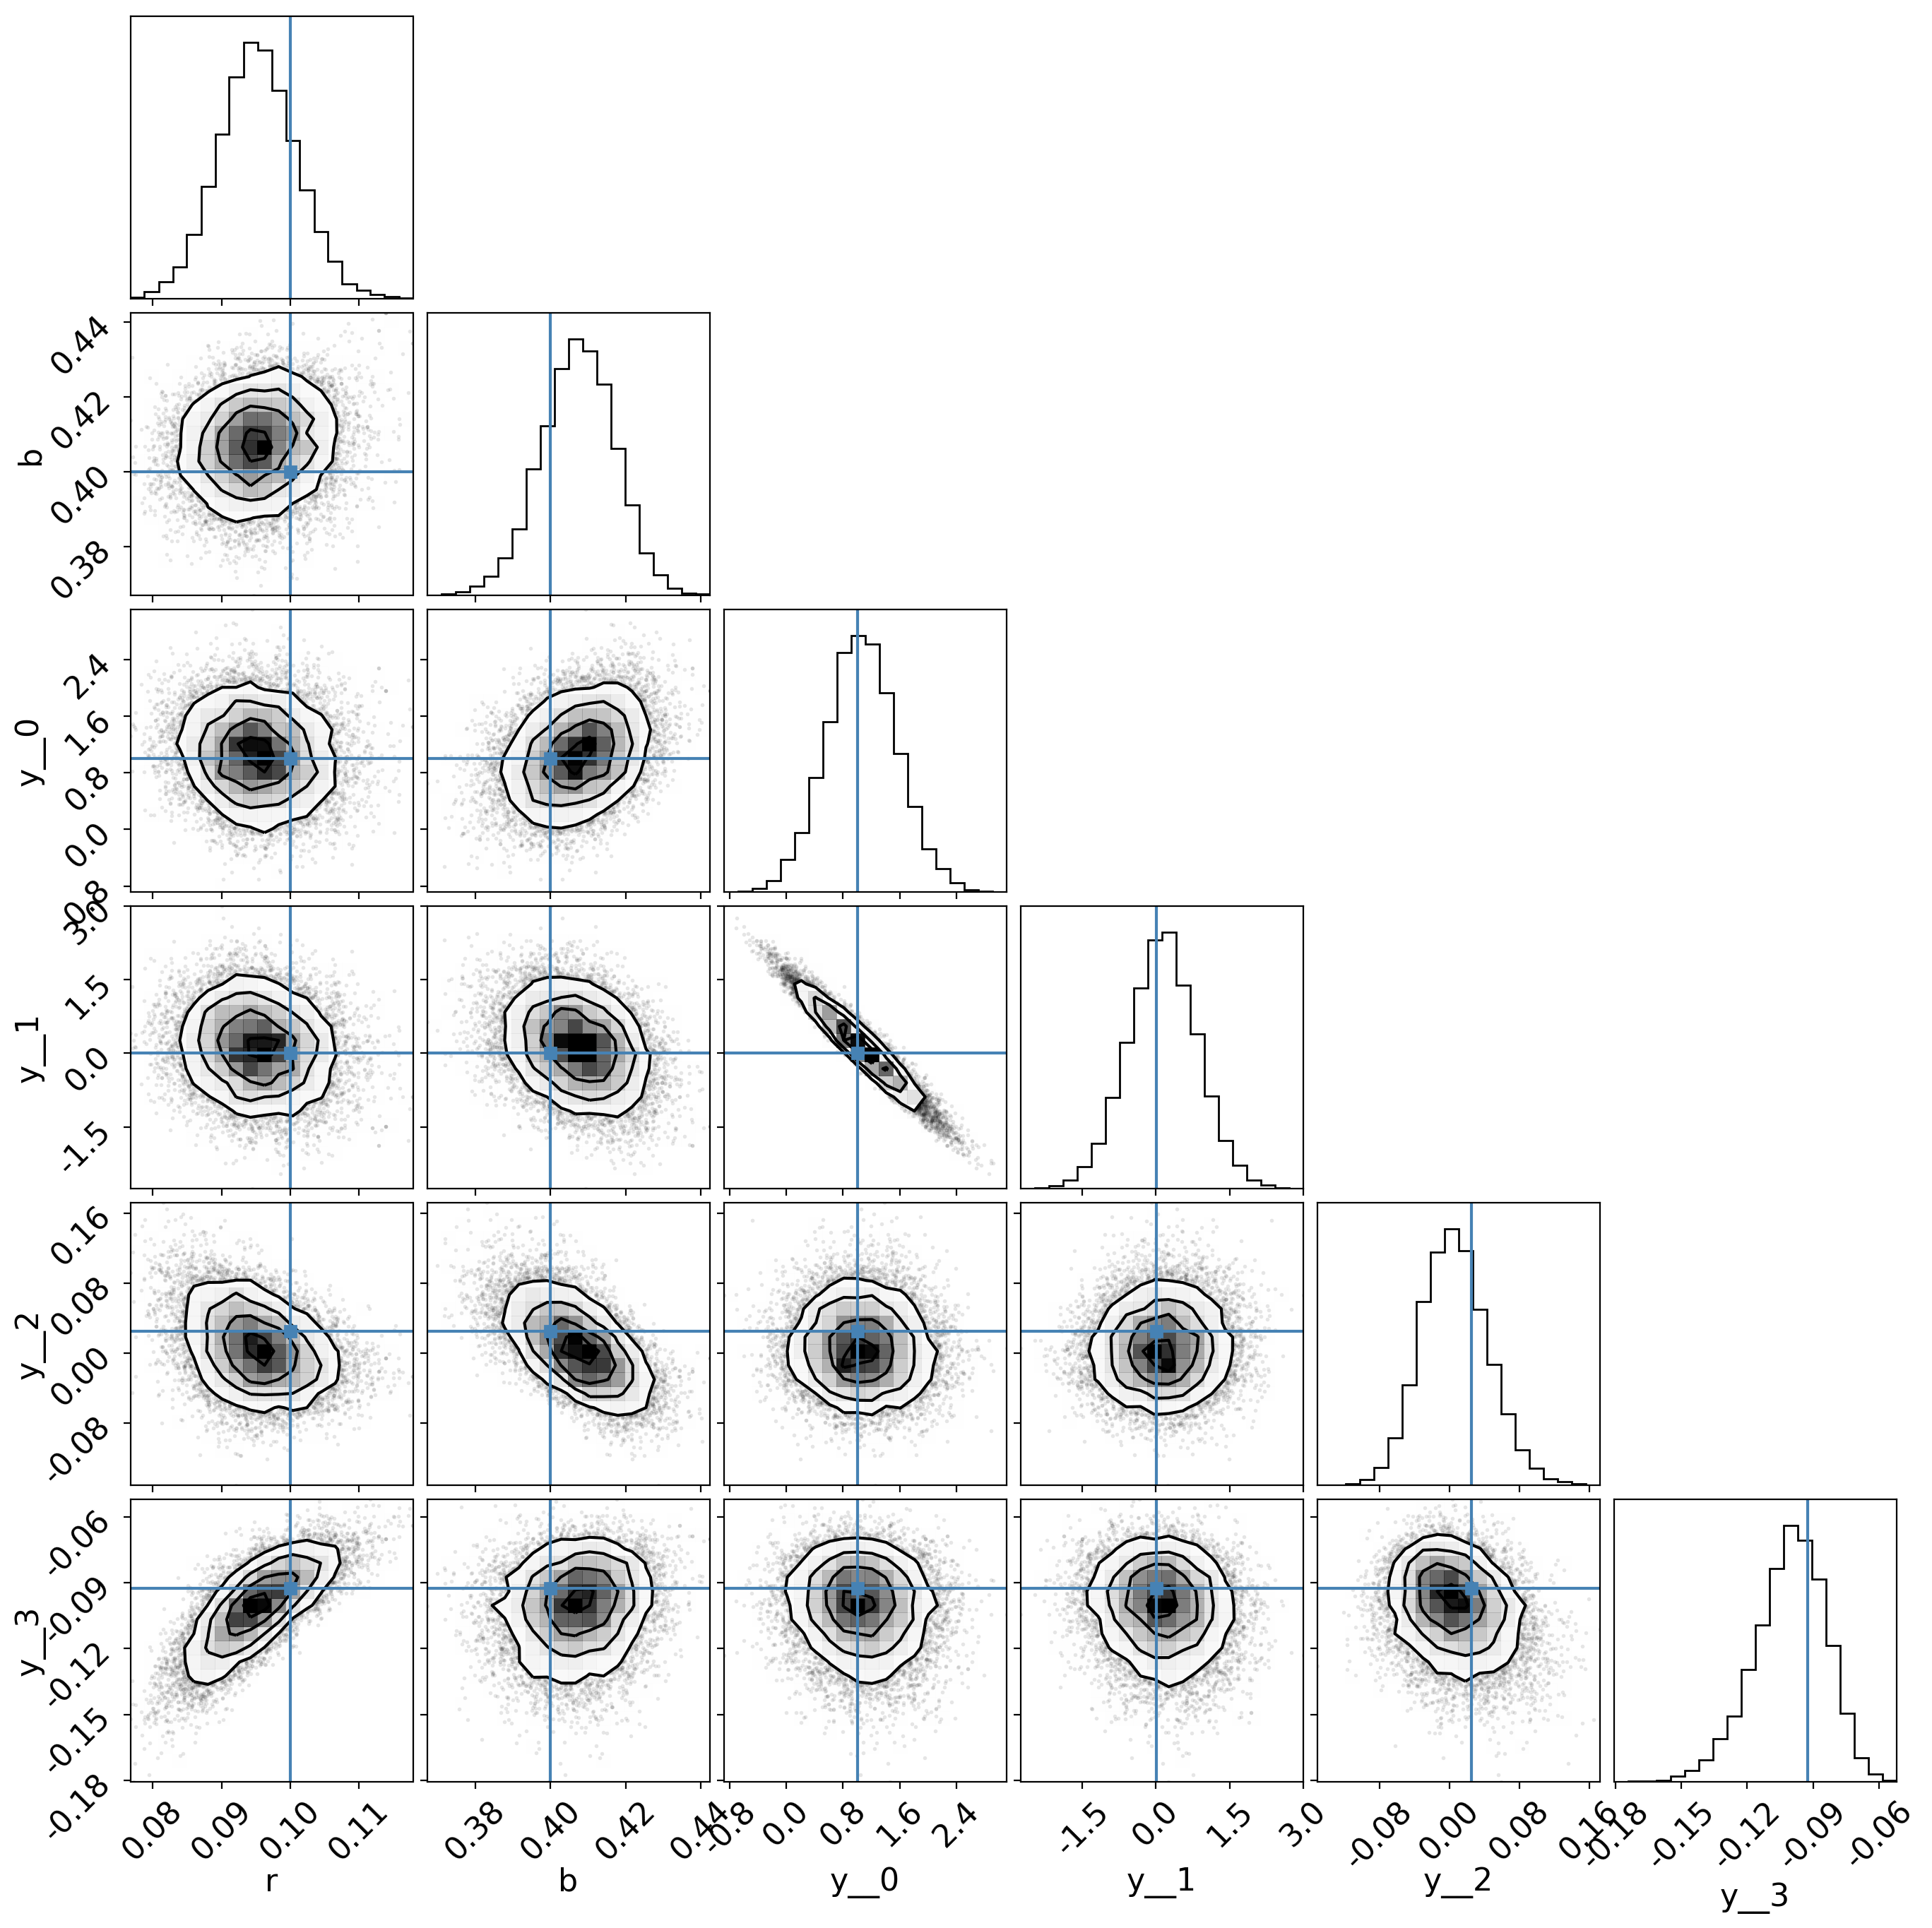

In [41]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["r", "b", "y"])
corner.corner(samples, truths=[0.1, 0.4, *y_true]);